In [1]:
import numpy as np
from numpy.fft import fft
import matplotlib.pyplot as plt
import scipy.io.wavfile as spwav
#from mpldatacursor import datacursor
import sys
from IPython.display import Audio

plt.style.use('ggplot')

# Note: this epoch list only holds for "test_vector_all_voiced.wav"
epoch_marks_orig = np.load("test_vector_all_voiced_epochs.npy")
F_s, audio_data = spwav.read("test_vector_all_voiced.wav")
N = len(audio_data)

In [33]:
def tune(audio_data, F_new):
    N = len(audio_data)
    new_epoch_spacing = int(np.round(F_s / F_new))
    audio_out = np.zeros(N)
    
    epoch_idx = 1
    for i in range(0, N, new_epoch_spacing):        
        # find the closest epoch
        dists = np.abs(epoch_marks_orig[epoch_idx - 1:epoch_idx + 2] - i)
        j = np.argmin(dists)
        epoch_idx += j
        epoch_idx = np.minimum(epoch_idx, epoch_marks_orig.shape[0] - 2)
        closest_epoch = epoch_marks_orig[epoch_idx]
    
        # approximate impulse response with hamming window
        P_0 = int(np.abs(epoch_marks_orig[epoch_idx + 1] - epoch_marks_orig[epoch_idx - 1]) / 2)
    
        h = np.float32(audio_data[closest_epoch-P_0:closest_epoch+P_0+1])

        # normalize h (can play around with diff methods)
        h /= np.max(h2) # np.sum(h * h)
        
        windowLength = 2 * P_0 + 1
        hWindowed = h * np.hanning(windowLength)
    
        # overlap and add
        length = np.minimum(i+windowLength, N) - i
        audio_out[i:i+length] += hWindowed[:length]

    return audio_out

tuned_audio = tune(audio_data, 440)

#### Get Target Pitch From Note Number

In [23]:
def noteToFreq(noteNumber):
    return 440 * 2**((noteNumber - 69) / 12)

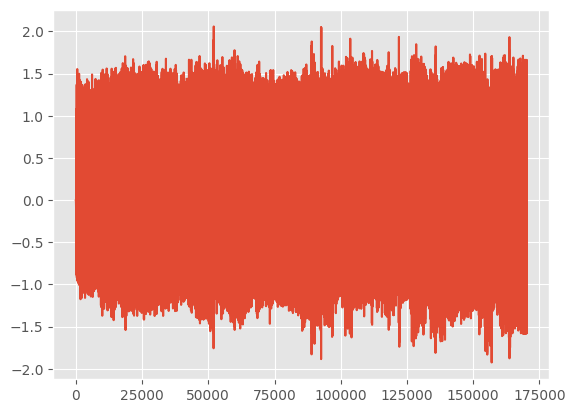

In [36]:
freq = noteToFreq(69) # A 440hz
tuned_audio = tune(audio_data, freq)
Audio(tuned_audio, rate=F_s)
plt.plot(tuned_audio)

#### ADSR
Attack, Decay, and Release are measured in ms. Sustain is a value between 0 and 1 to represent a fraction of the max volume.

In [54]:
hold = 500 # (ms) how long to wait in sustain phase before triggering release (this event will eventually be controlled by the user releasing an onscreen piano key)
def ADSR(Attack, Decay, Sustain, Release):
    attackLen = np.int32(np.round(Attack * 0.0001 * F_s))
    decayLen = np.int32(np.round(Decay * 0.0001 * F_s))
    holdLen = np.int32(np.round(hold * 0.0001 * F_s))
    releaseLen = np.int32(np.round(Release * 0.0001 * F_s))
    
    envelope = np.zeros(attackLen + decayLen + holdLen + releaseLen + 3) # +3 because while loops add an extra sample

    # Attack Stage
    attackInc = 1.0 / np.float32(attackLen)
    value = 0.0
    n = 0
    while (value < 1.0):
        envelope[n] = value
        value += attackInc
        value = np.minimum(value, 1.0)
        n += 1

    # Decay Stage
    DecayInc = (1.0 - Sustain) / np.float32(decayLen)
    while (value > Sustain):
        envelope[n] = value
        value -= DecayInc
        value = np.maximum(value, Sustain)
        n += 1

    # Sustain Stage (while holding down key)
    for _ in range(holdLen):
        envelope[n] = Sustain
        n += 1

    # Decay Stage
    ReleaseInc = Sustain / np.float32(releaseLen)
    while (value > 0.0):
        envelope[n] = value
        value -= ReleaseInc
        value = np.maximum(value, 0.t 0)
        n += 1

    return envelope

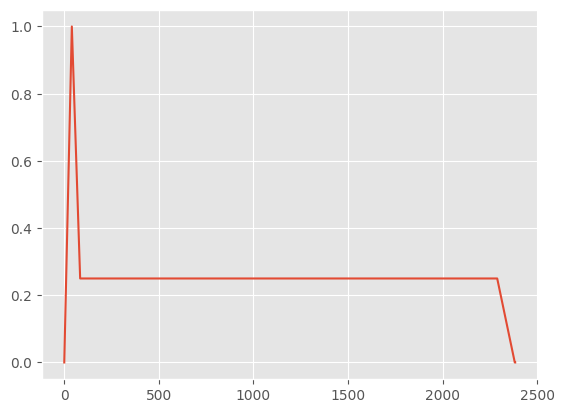

In [55]:
envelope = ADSR(9, 10, 0.25, 21)
plt.plot(envelope)

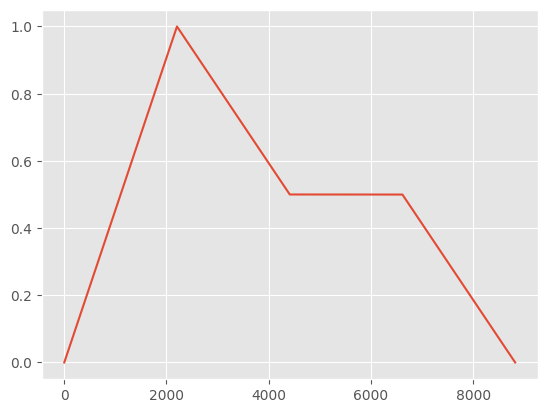

In [56]:
envelope = ADSR(500, 500, 0.5, 500)
plt.plot(envelope)

#### Single Pole LPF

In [106]:
class LP:    
    def __init__(self, F_s):
        self.sampleRate = F_s
        self.prevSample = 0.0
        self.prevOutSample = 0.0

    def restart(self):
        self.prevSample = 0.0
        self.prevOutSample = 0.0

    def calcG(self, cutoff):
        return 1 - np.exp(-2.0 * np.pi * cutoff / self.sampleRate)

    def processSample(self, sample, g):
        outSample = g * (1.0 / 1.3 * sample + 0.3 / 1.3 * self.prevSample - self.prevOutSample) + self.prevOutSample

        self.prevSample = sample
        self.prevOutSample = outSample
        
        return outSample

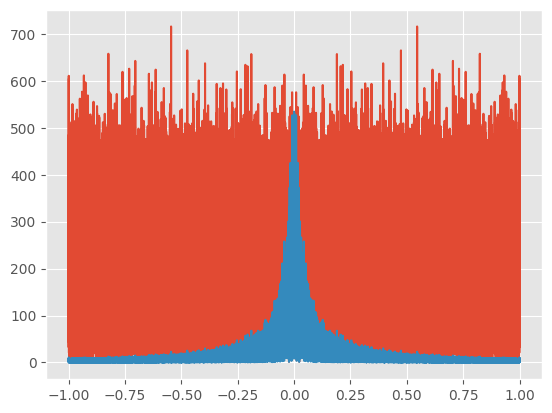

In [107]:
testNoise = np.random.uniform(-1.0, 1.0, F_s * 3)

freqLabels = np.linspace(-1.0, 1.0, testNoise.shape[0])

# spectrum plot before
spectrum = np.fft.fftshift(np.fft.fft(testNoise))
plt.plot(freqLabels, np.abs(spectrum))

# filter the noise
filteredNoise = np.zeros(testNoise.shape)

cutoff = 440 # hz
lowpassFilter = LP(F_s)
for n in range(len(testNoise)):
    g = lowpassFilter.calcG(cutoff)
    filteredNoise[n] = lowpassFilter.processSample(testNoise[n], g)
    
# spectrum plot after
spectrum = np.fft.fftshift(np.fft.fft(filteredNoise))
plt.plot(freqLabels, np.abs(spectrum))

In [75]:
Audio(testNoise, rate=F_s)

In [76]:
Audio(filteredNoise, rate=F_s)

#### Full Filter

In [110]:
class Filter:
    def __init__(self, F_s, resonance, numCascades):
        self.LPs = [LP(F_s) for _ in range(numCascades)]
        self.filterMags = [0] + [1.0 / (numCascades) for _ in range(numCascades)] # ABCDE in diagram

        self.comp = 0.5
        self.res = resonance

        self.filteredSample = 0.0

    def processSample(self, sample, cutoff):
        g = self.LPs[0].calcG(cutoff)
        
        feedback = self.res * ((4 * np.tanh(self.filteredSample)) - (sample * self.comp))
        self.filteredSample = sample - feedback
        
        for filter in self.LPs:
            self.filteredSample = filter.processSample(self.filteredSample, g)

        return self.filteredSample 
        

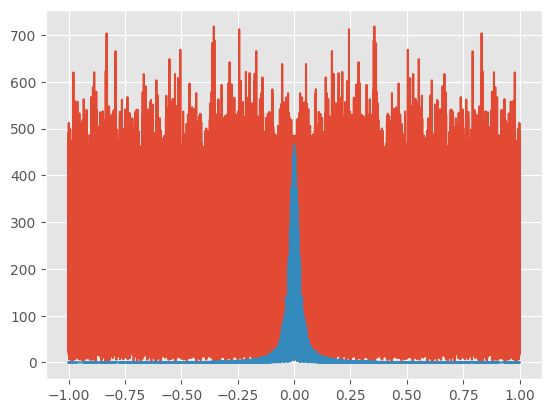

In [114]:
testNoise = np.random.uniform(-1.0, 1.0, F_s * 3)

freqLabels = np.linspace(-1.0, 1.0, testNoise.shape[0])

# spectrum plot before
spectrum = np.fft.fftshift(np.fft.fft(testNoise))
plt.plot(freqLabels, np.abs(spectrum))

# filter the noise
filteredNoise = np.zeros(testNoise.shape)

cutoff = 440 # hz
filter = Filter(F_s, 0.01, 2)
for n in range(len(testNoise)):
    filteredNoise[n] = filter.processSample(testNoise[n], cutoff)
    
# spectrum plot after
spectrum = np.fft.fftshift(np.fft.fft(filteredNoise))
plt.plot(freqLabels, np.abs(spectrum))